In [1]:
import pandas as pd
from pandas import DataFrame

import lasio
import glob 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

time: 0 ns (started: 2021-03-02 22:57:00 -06:00)


In [2]:
# Get list of las files in the folder

path = 'Train Data set'
files = glob.glob(path + "/*.las")

time: 15 ms (started: 2021-03-02 22:57:00 -06:00)


In [3]:
# Create well-wise dataframes and populate with logs from the las files

i = 1

for file in files:
    las = lasio.read(file)
    globals()[str("Well_"+str(i))] = las.df().reset_index().fillna(0)
    globals()[str("Well_"+str(i))]['Well Name'] = "Well_"+str(i)
    globals()[str("Well_"+str(i))]['Latitude'] = las.well.SLAT.value
    globals()[str("Well_"+str(i))]['Longitude'] = las.well.SLON.value
    i += 1

time: 3min 14s (started: 2021-03-02 22:57:00 -06:00)


In [4]:
# Create exploratory dataframe with surface locations and available logs to help us identify the inputs

wells = []
lat = []
lon = []
keys = []
logcount = []
units = []
uniqueunits = []
descrs = []
depth = []
i = 1

for file in files:
    well = "Well_"+str(i)
    las = lasio.read(file)
    latitude = las.well.SLAT.value
    longitude = las.well.SLON.value
    key = las.keys()
    md = las.well.STOP.value
    keycount = len(key)
    unit = []
    descr = []
    for j in range(keycount):
        unit.append(las.curves.items()[j][1].unit)
        descr.append(las.curves.items()[j][1].descr)
        j+=1
    i+=1
    uniqueunit = list(set(unit))
    lat.append(latitude)
    lon.append(longitude)
    depth.append(md)
    keys.append(key)
    logcount.append(keycount)
    wells.append(well)
    units.append(unit)
    uniqueunits.append(uniqueunit)
    descrs.append(descr)
    
welldf = DataFrame({'Wellname':wells,'Latitude':lat,'Longitude':lon,'Depth':depth, 'Log Count':logcount,'Log List':keys,
                    'Unit List':units, 'Unique Units':uniqueunits, 'Description': descrs})

time: 3min 12s (started: 2021-03-02 23:00:14 -06:00)


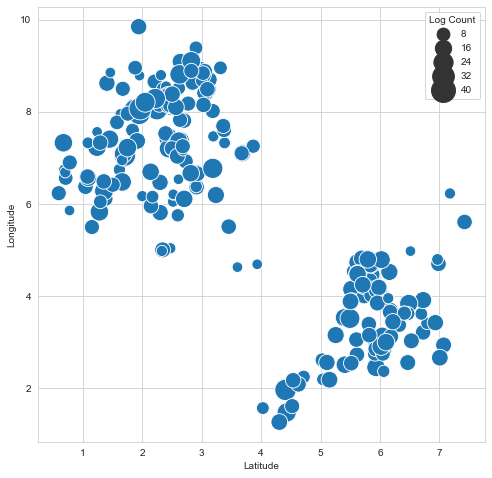

time: 281 ms (started: 2021-03-02 23:03:26 -06:00)


In [5]:
# Plot the lat,long and log count to get an idea on how the data is distributed

plt.figure(figsize=(8,8))
sns.scatterplot(x ='Latitude', y = 'Longitude', data = welldf, size= 'Log Count', sizes = (100,600))

# We see that there are two clusters of wells based on locations

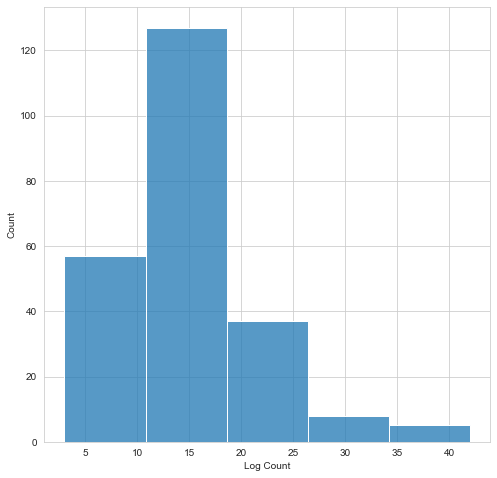

time: 219 ms (started: 2021-03-02 23:03:27 -06:00)


In [6]:
# plot a histogram to see the number of logs available in each 

plt.figure(figsize=(8,8))
sns.histplot(welldf['Log Count'], bins = 5)

In [7]:
# Using the log list column in our exploratory DF
# We can try to figure out if the naming schemes of all the well logs is similar.

welldf_explode = welldf.explode('Log List')
welldf_explode['Units'] = list(welldf.explode('Unit List')['Unit List'])
welldf_explode['Description'] = list(welldf.explode('Description')['Description'])
welldf_explode.rename(columns = {'Log List':'Logs'}, inplace = True)
welldf_explode.drop(['Unit List'],axis = 1, inplace = True)

time: 16 ms (started: 2021-03-02 23:03:27 -06:00)


Text(0.5, 1.0, 'Log Mnemonic Count in 234 Wells')

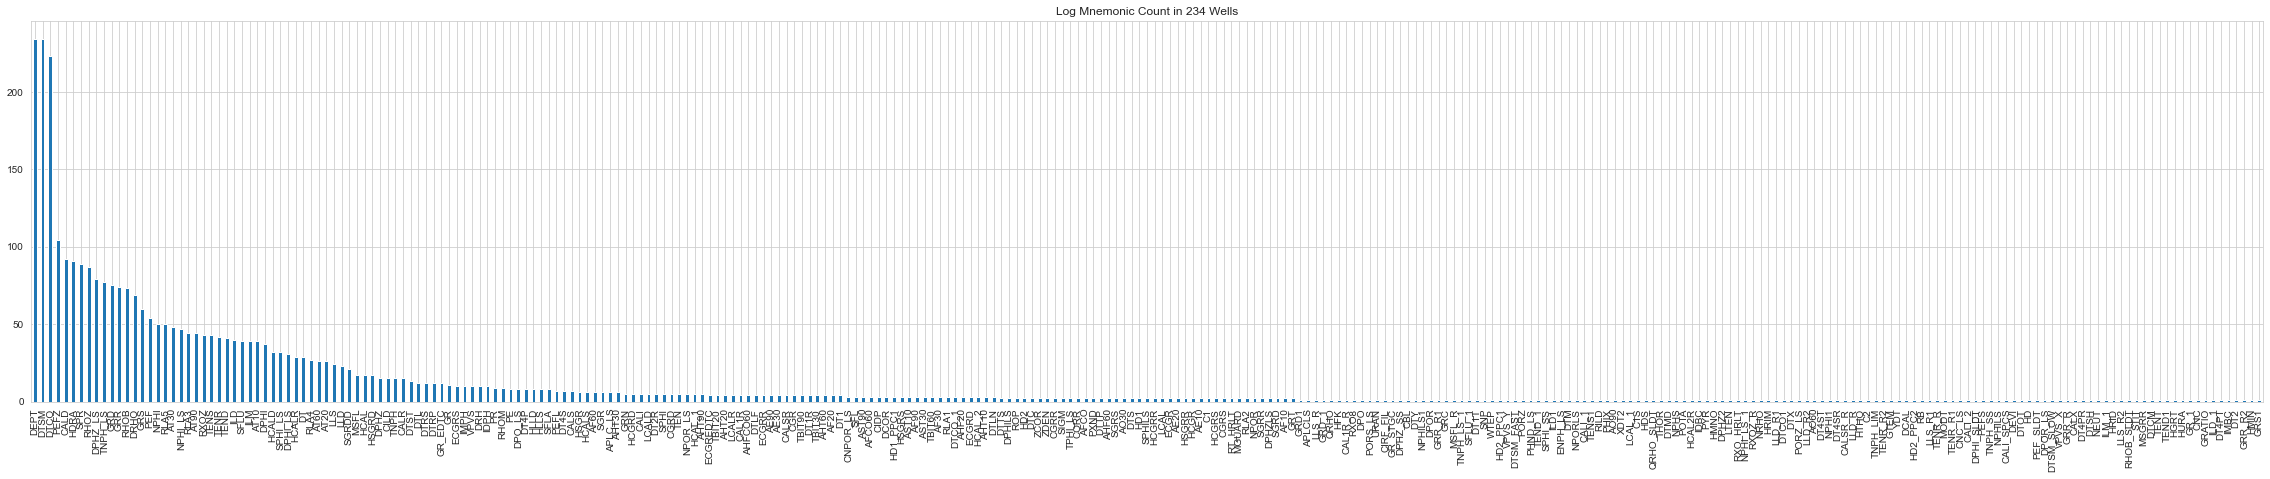

time: 5.48 s (started: 2021-03-02 23:03:27 -06:00)


In [8]:
# Plot the logs available based on mnemonics 
plt.figure(figsize=(40,7))
welldf_explode['Logs'].value_counts().plot.bar()
plt.title('Log Mnemonic Count in 234 Wells')

# We can see that the naming scheme is not really similar. 
# Only Depth and DTSM (target variable) are available for all the 234 wells.
# Other logs are either named differntly or unavailable. We might have to rename some of the wells and condition the dataset.

Text(0.5, 1.0, 'Unit Count in 234 Wells')

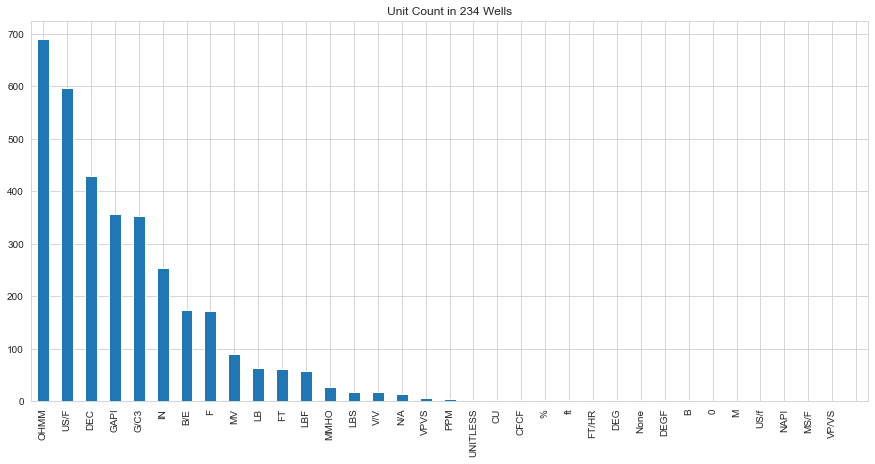

time: 407 ms (started: 2021-03-02 23:03:32 -06:00)


In [9]:
# We can plot the number of logs based on units listed in the las files

plt.figure(figsize=(15,7))
welldf_explode['Units'].value_counts().plot.bar()
plt.title('Unit Count in 234 Wells')

# We can see that there are multiple logs with same units making the highest log count to 700 when the number of wells are 234

Text(0.5, 1.0, 'Entire Well')

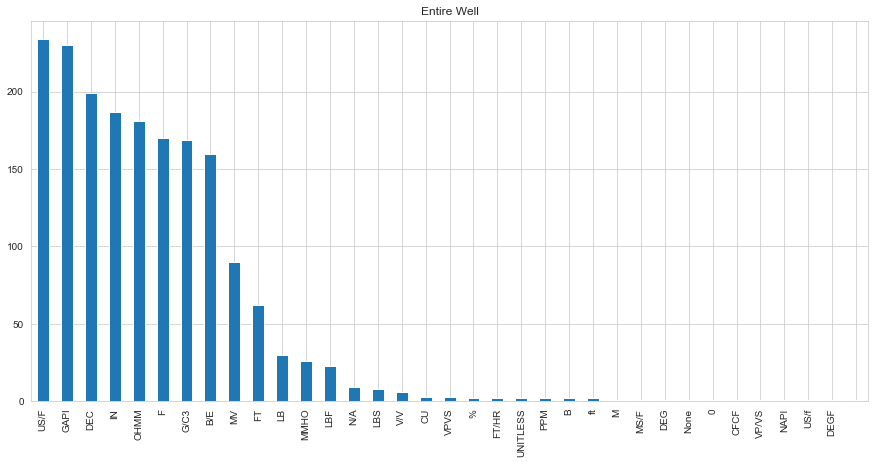

time: 328 ms (started: 2021-03-02 23:03:33 -06:00)


In [10]:
# Lets plot the only the unique log units available in a well

plt.figure(figsize=(15,7))
welldf.explode('Unique Units')['Unique Units'].value_counts().plot.bar()
plt.title('Entire Well')

# Feature Selection and  Compound Feature Creation

Based on the log availability, we can select the following freatures initially

1. LAT, LONG: Relative location to include spatial variation
2. DEPT: Available for all the wells, might have to eliminate some laterals from the training set
3. DTSM: Available for all the wells, one well has DTSM with different units, check magnitude and eliminate if necessary
4. DTCO: Available for 223 Wells, we can impute the rest
5. RHOB: Available for 169 wells, some of them are density correction logs which needs to be removed and rest needs to be imputed
6. PEF: Available for 160 wells, rest need to be imputed (They are named differently, so we can create a new feature with an average value if more than one is available in a well)
7. GR: Available for 230 wells, an average GR feature needs to be created and imputed
8. NPHI: Available for 199 wells, an average NPHI feature needs to be created and imputed
9. RES: Available for 181 wells, but many different variations are available so depending on the magnitudes, we might have to eliminate the entire feature
10. CALI: Caliper logs are available for 187 wells but might not be effective in predicting target variables


In [11]:
# Append the las files for all the wells into a single dataframe

well_logs = []
for i in range (1, len(wells)+1):
    well_logs.append(globals()["Well_"+str(i)])
    
welldf_entire = pd.concat(well_logs)

# Replacing zero values with NaNs
welldf_entire.replace(0,np.nan,inplace=True)

# Replacing negative values with NaNs
welldf_entire[welldf_entire.DTSM < 0] = np.nan

# Dropping the columns where DTSM(target variable) is null
welldf_entire.dropna(subset = ['DTSM'], inplace = True)

time: 33.7 s (started: 2021-03-02 23:03:33 -06:00)


In [18]:
# Based on the units, lets select the log mnemonics that we can create a compound feature

GAPI = list(set(welldf_explode[welldf_explode['Units'] == "GAPI"]['Logs'].value_counts().index))

# Remove sprectral gamma ray logs from the list of logs having units GAPI
SGR = ['SGRDD','HSGRD','HSGRS','SGRS','HSGR','SGR','HSGRR','MSGRR','SGRD','SGRDD','SGRR','HCGR']

time: 0 ns (started: 2021-03-02 23:07:39 -06:00)


In [19]:
for element in GAPI:
    if element in SGR:
        GAPI.remove(element)

['HGRT',
 'GRR',
 'SGRD',
 'GRS',
 'GR_1',
 'ECGREDTC',
 'ECGRS',
 'HCGRD',
 'GRR_R2',
 'GRR_R',
 'CGRD',
 'GR_EDTC',
 'GRD1',
 'ECGR',
 'CGRR',
 'GRC',
 'SGRDD',
 'ECGRD',
 'GRS1',
 'CGR',
 'GRN',
 'ECGRR',
 'GRR_R1',
 'CGRS',
 'GR',
 'HCGRS',
 'GRD',
 'GRD_1',
 'GRT',
 'HCGRR',
 'GR_STGC']

time: 0 ns (started: 2021-03-02 23:07:40 -06:00)


In [20]:
DEC = list(set(welldf_explode[welldf_explode['Units'] == "DEC"]['Logs'].value_counts().index))

# One of the DTSM log has the units of DEC, removing it from the porosity logs
DEC.remove('DTSM')

time: 0 ns (started: 2021-03-02 23:07:49 -06:00)


In [22]:
IN = list(set(welldf_explode[welldf_explode['Units'] == "IN"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:08:11 -06:00)


In [23]:
OHMM = list(set(welldf_explode[welldf_explode['Units'] == "OHMM"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:08:15 -06:00)


In [28]:
GC3  = list(set(welldf_explode[welldf_explode['Units'] == "G/C3"]['Logs'].value_counts().index))

# Remove density correction logs from the list of logs having units G/C3
DCORR = ['HDRA','DRHO','DRH','ZCOR','DCOR','CORR','QRHO','QRHO_SLDT','QRHO']

time: 0 ns (started: 2021-03-02 23:09:04 -06:00)


In [29]:
for element in GC3:
    if element in DCORR:
        GC3.remove(element)

time: 0 ns (started: 2021-03-02 23:09:07 -06:00)


In [30]:
BE = list(set(welldf_explode[welldf_explode['Units'] == "B/E"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:09:08 -06:00)


In [31]:
# Take the row average of the features to create average features if more than one kind of log is available

welldf_entire['GR_average'] = welldf_entire[GAPI].mean(axis = 1)
welldf_entire['PHI_average'] = welldf_entire[DEC].mean(axis = 1)
welldf_entire['CALI_average'] = welldf_entire[IN].mean(axis = 1)
welldf_entire['RES_average'] = welldf_entire[OHMM].mean(axis = 1)
welldf_entire['RHOB_average'] = welldf_entire[GC3].mean(axis = 1)
welldf_entire['PEF_average'] = welldf_entire[BE].mean(axis = 1)

time: 3.59 s (started: 2021-03-02 23:09:09 -06:00)


In [32]:
# Make a df with selected features

features_entire =  welldf_entire[['DEPT','Latitude','Longitude','DTCO','RHOB_average','PEF_average',
                                  'GR_average','PHI_average','CALI_average','RES_average', 'DTSM']]

time: 78 ms (started: 2021-03-02 23:09:13 -06:00)


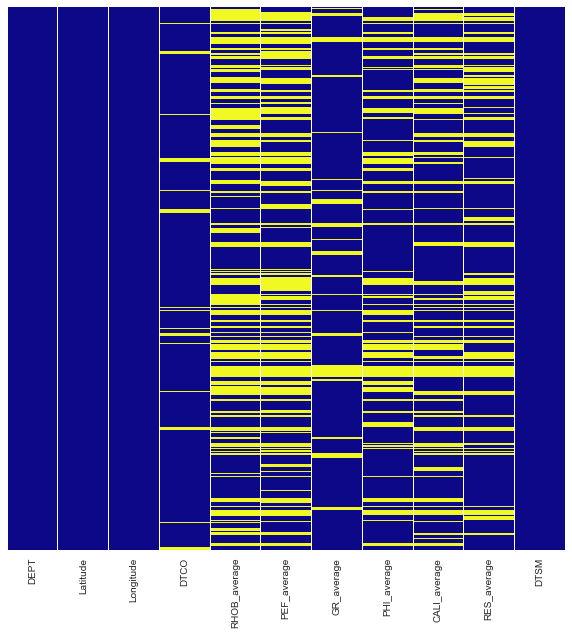

time: 13.8 s (started: 2021-03-02 23:09:13 -06:00)


In [33]:
# Null check on final features selected, we will impute the points shown in yellow

plt.figure(figsize=(10,10))
sns.heatmap(features_entire.isnull(), cmap = 'plasma', yticklabels= False, cbar = False)

In [34]:
# Replacing negative values with nans 
for column in features_entire.columns:
    features_entire[column].loc[features_entire[column] <= 0] = np.nan

time: 47 ms (started: 2021-03-02 23:09:27 -06:00)


# Model Building

In [35]:
# Splitting the data into train and test for self-validation for all three dataframes

from sklearn.model_selection import train_test_split
X = features_entire.drop('DTSM', axis =1)
y = features_entire.DTSM

time: 359 ms (started: 2021-03-02 23:09:40 -06:00)


In [36]:
# As this is a regression problem, the magnitude distribution can sometimes affect the model prediction. 
# So it will be ideal to scale the features
# Then we can use the iterative imputer to fill the missing values of the scaled features
# Then finally you can put this through ML model, Random Forest regressor in this case

from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import Pipeline

# define model pipeline

scaler = RobustScaler()
imputer = IterativeImputer(random_state= 42, missing_values = np.nan)

time: 438 ms (started: 2021-03-02 23:10:03 -06:00)


# Building a model using the tuned hyperparameters

In [37]:
model = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.05, max_depth = 5,
                     min_child_weight = 10, n_estimators = 500, subsample = 0.7, 
                     random_state = 42, n_jobs = -1, verbosity = 2)

pipeline = Pipeline(steps=[('s',scaler),('i', imputer), ('m', model)])

time: 0 ns (started: 2021-03-02 23:10:07 -06:00)


# Test wells conditioning for the final leaderboard

In [38]:
# Read the test well las files and save them as dataframes

test = 'All Test Data'
testfiles = glob.glob(test + "/*.las")

i =1
for testfile in testfiles:
    las = lasio.read(testfile)
    globals()[str("Test_Well_"+str(i))] = las.df().reset_index().fillna(0)
    globals()[str("Test_Well_"+str(i))]['Well Name'] = str(testfile)[14:-4]
    globals()[str("Test_Well_"+str(i))]['Latitude'] = las.well.SLAT.value
    globals()[str("Test_Well_"+str(i))]['Longitude'] = las.well.SLON.value
    i += 1


time: 8.25 s (started: 2021-03-02 23:10:19 -06:00)


In [39]:
# Create exploratory dataframe for test wells to check on the logs available

testwells = []
lat = []
lon = []
keys = []
logcount = []
units = []
uniqueunits = []
descrs = []
depth = []
i = 1

for testfile in testfiles:
    testwell = str(testfile)[14:-4]
    las = lasio.read(testfile)
    latitude = las.well.SLAT.value
    longitude = las.well.SLON.value
    key = las.keys()
    md = las.well.STOP.value
    keycount = len(key)
    unit = []
    descr = []
    for j in range(keycount):
        unit.append(las.curves.items()[j][1].unit)
        descr.append(las.curves.items()[j][1].descr)
        j+=1
    i+=1
    uniqueunit = list(set(unit))
    lat.append(latitude)
    lon.append(longitude)
    depth.append(md)
    keys.append(key)
    logcount.append(keycount)
    testwells.append(testwell)
    units.append(unit)
    uniqueunits.append(uniqueunit)
    descrs.append(descr)
    
test_welldf = DataFrame({'Wellname':testwells,'Latitude':lat,'Longitude':lon,'Depth':depth, 'Log Count':logcount,'Log List':keys,
                    'Unit List':units, 'Unique Units':uniqueunits, 'Description': descrs})

time: 8.17 s (started: 2021-03-02 23:10:27 -06:00)


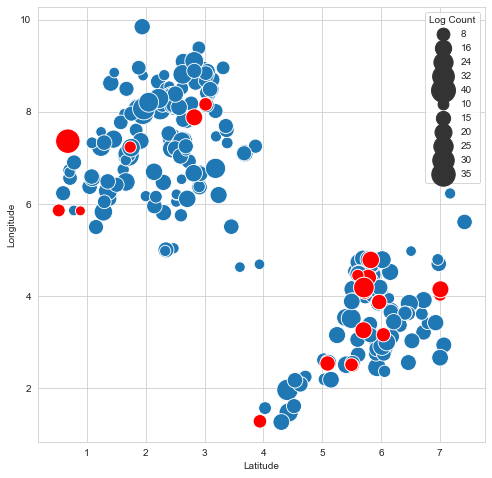

time: 312 ms (started: 2021-03-02 23:10:35 -06:00)


In [40]:
# Plot the lat,long and log count to get an idea on how the data is distributed

plt.figure(figsize=(8,8))
sns.scatterplot(x ='Latitude', y = 'Longitude', data = welldf, size= 'Log Count', sizes = (100,600))
sns.scatterplot(x ='Latitude', y = 'Longitude', data = test_welldf, size= 'Log Count', sizes = (100,600),color = 'red')

# We can see that the relative locations of the test wells are well within the train dataset space

In [41]:
# Using the log list column in our exploratory DF
# We can try to figure out if the naming schemes of all the test well logs is similar.

test_welldf_explode = test_welldf.explode('Log List')
test_welldf_explode['Units'] = list(test_welldf.explode('Unit List')['Unit List'])
test_welldf_explode['Description'] = list(test_welldf.explode('Description')['Description'])
test_welldf_explode.rename(columns = {'Log List':'Logs'}, inplace = True)
test_welldf_explode.drop(['Unit List'],axis = 1, inplace = True)

# Append the las files for all the wells into a single dataframe

test_well_logs = []
for i in range (1, len(testwells)+1):
    test_well_logs.append(globals()["Test_Well_"+str(i)])
    
test_welldf_entire = pd.concat(test_well_logs)

time: 125 ms (started: 2021-03-02 23:14:03 -06:00)


In [42]:
# Based on the units, lets select the log mnemonics that we can create a compound feature

GAPI = list(set(test_welldf_explode[test_welldf_explode['Units'] == "GAPI"]['Logs'].value_counts().index))

# Remove sprectral gamma ray logs from the list of logs having units GAPI
SGR = ['SGRDD','HSGRD','HSGRS','SGRS','HSGR','SGR','HSGRR','MSGRR','SGRD','SGRDD','SGRR','HCGR']

time: 0 ns (started: 2021-03-02 23:14:07 -06:00)


In [43]:
for element in GAPI:
    if element in SGR:
        GAPI.remove(element)

time: 0 ns (started: 2021-03-02 23:14:08 -06:00)


In [45]:
DEC = list(set(test_welldf_explode[test_welldf_explode['Units'] == "DEC"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:14:11 -06:00)


In [46]:
IN = list(set(test_welldf_explode[test_welldf_explode['Units'] == "IN"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:14:12 -06:00)


In [47]:
OHMM = list(set(test_welldf_explode[test_welldf_explode['Units'] == "OHMM"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:14:13 -06:00)


In [48]:
GC3  = list(set(test_welldf_explode[test_welldf_explode['Units'] == "G/C3"]['Logs'].value_counts().index))

# Remove density correction logs from the list of logs having units G/C3
DCORR = ['HDRA','DRHO','DRH','ZCOR','DCOR','CORR','QRHO','QRHO_SLDT','QRHO']

time: 0 ns (started: 2021-03-02 23:14:14 -06:00)


In [49]:
for element in GC3:
    if element in DCORR:
        GC3.remove(element)

time: 0 ns (started: 2021-03-02 23:14:15 -06:00)


In [51]:
BE = list(set(test_welldf_explode[test_welldf_explode['Units'] == "B/E"]['Logs'].value_counts().index))

time: 0 ns (started: 2021-03-02 23:14:28 -06:00)


In [52]:
test_welldf_entire['GR_average'] = test_welldf_entire[GAPI].mean(axis = 1)
test_welldf_entire['PHI_average'] = test_welldf_entire[DEC].mean(axis = 1)
test_welldf_entire['CALI_average'] = test_welldf_entire[IN].mean(axis = 1)
test_welldf_entire['RES_average'] = test_welldf_entire[OHMM].mean(axis = 1)
test_welldf_entire['RHOB_average'] = test_welldf_entire[GC3].mean(axis = 1)
test_welldf_entire['PEF_average'] = test_welldf_entire[BE].mean(axis = 1)

time: 406 ms (started: 2021-03-02 23:14:30 -06:00)


In [53]:
test_features =  test_welldf_entire[['DEPT','Latitude','Longitude','DTCO','RHOB_average','PEF_average',
                                  'GR_average','PHI_average','CALI_average','RES_average']]

# fill null values as zeroes
test_features.fillna(0, axis =1, inplace = True)

# Replacing negative values with zeroes
for column in test_features.columns:
    test_features[column].loc[test_features[column] <= 0] = 0

time: 78 ms (started: 2021-03-02 23:14:42 -06:00)


# Creating a submission file

In [54]:
# Fit the data too the pipeline using the complete dataset
pipeline.fit(X, y)

# Predict the DTSM for test Wells

test_predictions = pipeline.predict(test_features)

# Make a Dataframe of predictions of test dataset
submission_file = test_welldf_entire[['Well Name','DEPT']]
submission_file['DTSM'] = test_predictions

[23:15:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:15:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:15:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:15:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:15:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:16:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:16:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:16:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:16:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 

[23:16:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:16:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:16:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:16:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:16:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:16:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:16:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:16:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:16:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:16:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:16:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:16:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:17:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:17:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:17:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:17:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:17:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:17:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[23:17:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:17:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:17:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:17:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:17:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:17:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:18:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:18:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:18:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:18:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:18:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:18:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[23:18:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:18:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:18:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:18:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:18:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:18:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[23:19:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:19:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:19:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:19:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:19:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:19:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 

[23:19:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:19:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:19:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:19:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:19:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:19:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 

In [56]:
# Exporting the predicted well logs to their xlsx file
for testwell in testwells:
    submission_file[submission_file['Well Name'] == str(testwell)].drop('Well Name', axis = 1).to_excel(str(testwell)+'.xlsx', index = False)

time: 7.3 s (started: 2021-03-02 23:21:15 -06:00)


In [62]:
# Checking the cross-validation scores
from sklearn.model_selection import cross_validate 
scores = cross_validate(pipeline, X, y, cv = 10, scoring = ('neg_root_mean_squared_error'))
print("RMSE for xGBoost Regression: ",np.average(scores.get('test_score')))

[23:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:28:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:28:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:28:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:28:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:28:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:29:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:29:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:29:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:29:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:29:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:29:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:29:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:29:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:29:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:29:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:29:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:29:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:30:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:30:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:30:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:30:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:30:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:30:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 

[23:30:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:30:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:30:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:30:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:30:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:30:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:31:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:31:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:31:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:31:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:31:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:31:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 

[23:31:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:31:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:31:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:31:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:31:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:31:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[23:31:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:31:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:31:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:31:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:31:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:31:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 

[23:32:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:32:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:32:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:33:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:33:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:33:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:33:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:33:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:33:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[23:33:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:33:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:33:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:33:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:33:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:33:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:34:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:34:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:34:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:34:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:34:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:34:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:34:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:34:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:34:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:34:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:34:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:34:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 

[23:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:35:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:35:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:35:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:35:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:35:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:35:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:35:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:35:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:35:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:35:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:35:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[23:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:35:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:36:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:36:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:36:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:36:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[23:36:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:36:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:36:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:36:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:36:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:36:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 

[23:37:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:37:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:37:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:37:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:38:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:38:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:38:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:38:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[23:38:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:38:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:39:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:39:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:39:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:39:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:39:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:39:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 

[23:39:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:39:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:39:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:39:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:39:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:39:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[23:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:40:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:40:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:40:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:40:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 

[23:40:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:40:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:40:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:40:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:40:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:40:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:40:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:40:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:40:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:40:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:40:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:40:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:41:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:41:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:41:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:41:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:41:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:41:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:42:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:42:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:42:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:42:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:42:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:42:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:43:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:43:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:43:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:43:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:43:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:43:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 

[23:43:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:43:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:43:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:43:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:43:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:43:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 

[23:44:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:44:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:44:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:44:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:44:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:44:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:44:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:44:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:45:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:45:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:45:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:45:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:45:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:45:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:45:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:45:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:45:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:45:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:45:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:45:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 

[23:45:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:46:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:46:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:46:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:46:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 

[23:46:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:46:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:46:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 

[23:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:47:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:47:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:47:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:48:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:48:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:48:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:48:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:48:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 

[23:48:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:48:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:48:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:48:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:48:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:49:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:49:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:49:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:49:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 

[23:49:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:49:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:49:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:49:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:49:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:49:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:50:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:50:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:50:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:50:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:50:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 

[23:50:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:50:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:50:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:50:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[23:51:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:51:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:51:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:51:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:51:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:51:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:51:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:51:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:51:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:51:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:51:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:51:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:52:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:52:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:52:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:52:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:52:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:52:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 

[23:53:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:53:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:53:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:53:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:53:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:53:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[23:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:53:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:53:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 

[23:54:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:54:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:54:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:54:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:54:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:54:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:55:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:55:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:55:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:55:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:55:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:55:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:55:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:55:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:55:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:55:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:55:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:55:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:56:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:56:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 

[23:56:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:56:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:56:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:56:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:56:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:56:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:57:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:57:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:57:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:57:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:57:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:57:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:57:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:57:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:57:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:57:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[23:58:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:58:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:58:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:58:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:58:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:58:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:58:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:58:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:58:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:58:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:58:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:58:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:59:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:59:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:59:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:59:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:59:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:59:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[23:59:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:59:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:59:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:59:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:59:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:59:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 

[00:00:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:00:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:00:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:00:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:00:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:00:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 

[00:00:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:00:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:00:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:00:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:00:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:00:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:01:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:01:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:01:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:01:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:01:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:01:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[00:01:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:01:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:01:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:01:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:01:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:01:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:02:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:02:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:02:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:02:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:02:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:02:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:02:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:02:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:02:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:02:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:02:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:03:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:03:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:03:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:03:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:03:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:03:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:03:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:03:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:03:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:03:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:03:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:03:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 

[00:03:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:04:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:04:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:04:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[00:04:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[00:04:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:04:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:04:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[00:04:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:04:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:04:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:04:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:05:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:05:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:05:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:05:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:05:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:05:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:05:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:05:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:05:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[00:05:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:05:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:05:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:06:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:06:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:06:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:06:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[00:06:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:06:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 

[00:06:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:06:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:06:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:06:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:06:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:06:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:07:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:07:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:07:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:07:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:07:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:07:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 

[00:07:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:07:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[00:07:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:07:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[00:07:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:07:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[00:08:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:08:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:08:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[00:08:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:08:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:08:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[00:08:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:08:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:08:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:08:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:08:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:08:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 

[00:09:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:09:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:09:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:09:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:09:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:09:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:10:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:10:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:10:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 

[00:10:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:10:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:10:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:10:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:10:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:10:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:11:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:11:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:11:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:11:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:11:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:11:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 

[00:11:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:11:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:11:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:11:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:11:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:11:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:12:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:12:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:12:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:12:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:12:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:13:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:13:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:13:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:13:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:13:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:13:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[00:13:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:13:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:13:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:13:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:13:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:13:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 

[00:13:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:13:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:13:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:13:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 

[00:14:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:14:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 

[00:14:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:14:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:14:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 

[00:15:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:15:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:15:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:15:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[00:15:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:15:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

[00:15:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:15:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[00:15:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:15:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:15:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[00:15:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 

[00:16:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:16:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:16:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:16:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:16:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[00:16:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 

# Saving all the conditioned data to save time and re-using a saved model

In [59]:
# Save conditioned and cleaned X and Y of bothe train and test datasets for easy reuse
features_entire.to_csv('Train_Set_Conditioned.txt', index = False)
test_features.to_csv('All_Test_Set_Conditioned.txt', index = False)

import pickle

# Save to file in the current working directory
pkl_filename = "spe_ml_model_final.pkl"


with open(pkl_filename, 'wb') as file:
    pickle.dump(pipeline, file)

time: 24.9 s (started: 2021-03-02 23:24:56 -06:00)


In [ ]:
# Load from file
import pickle
pkl_filename = "spe_ml_model_final.pkl"

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Make submission file

test_predictions = pickle_model.predict(test_features)
submission_file = test_welldf_entire[['Well Name','DEPT']]
submission_file['DTSM'] = test_predictions

# Exporting the predicted well logs to their xlsx file
for testwell in testwells:
    submission_file[submission_file['Well Name'] == str(testwell)].drop('Well Name', axis = 1).to_excel(str(testwell)+'.xlsx', index = False)
submission_file.to_csv('xgboost_tuned_new.csv')